# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [1]:
import numpy as np
import pandas as pd
from asl_data import AslDb


asl = AslDb() # initializes the database
asl.df.head() # displays the first five rows of the asl database, indexed by video and frame
asl.df

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1
      5         149     181      170      175     161      62  woman-1
      6         149     181      170      175     161      62  woman-1
      7         149     181      170      175     161      62  woman-1
      8         149     181      170      175     161      62  woman-1
      9         149     181      170      175     161      62  woman-1
      10        149     181      170      175     161      62  woman-1
      11        149     181      169      173     161      62  woman-1
      12        149     181      167      165     161      62  woman-1
      13        149     181      166      160     161      62  woman-1
      14        149     181      164      149     161      62  woman-1
      15        149     181      158      133     161      62  woman-1
      16        149     181      153      119     161      62  woman-1
      17        149     181      140      109     161      62  woman-1
      18        149     181      126      100     163      58  woman-1
      19        149     181      114       94     163      58  woman-1
      20        149     181      110       89     163      58  woman-1
      21        149     181      110       89     162      56  woman-1
      22        149     181      115       86     162      56  woman-1
      23        149     181      124       83     162      56  woman-1
      24        149     181      127       84     162      56  woman-1
      25        149     181      132       83     162      54  woman-1
      26        149     181      135       82     162      54  woman-1
      27        149     181      138       79     162      54  woman-1
      28        149     181      141       75     162      54  woman-1
      29        149     181      141       75     162      54  woman-1
...             ...     ...      ...      ...     ...     ...      ...
125   27        184     118      144      103     164      64  woman-1
      28        187     118      146      106     164      64  woman-1
      29        187     118      148      108     164      67  woman-1
      30        187     118      145      111     164      67  woman-1
      31        192     118      143      112     164      67  woman-1
      32        193     117      146      108     164      67  woman-1
      33        193     117      146      104     164      67  woman-1
      34        196     119      146      100     164      67  woman-1
      35        194     123      143      103     164      67  woman-1
      36        194     123      143      103     163      70  woman-1
      37        184     120      145      106     163      70  woman-1
      38        174     118      152      112     163      70  woman-1
      39        168     124      154      116     163      69  woman-1
      40        168     124      154      116     164      66  woman-1
      41        168     124      154      116     163      66  woman-1
      42        168     124      154      116     163      66  woman-1
      43        168     124      154      116     162      65  woman-1
      44        168     124      155      116     162      60  woman-1
      45        168     136      155      116     162      60  woman-1
      46        165     145      156      121     162      60  woman-1
      47        162     156      158      122     162      60  woman-1
      48        162     167      161      126     162      60  woman-1
      49        155     172      164      132     162      60  woman-1
      50        152     177      165 

In [2]:
asl.df.ix[98,1]  # look at the data available for an individual frame

left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

##### Try it!

In [3]:
from asl_utils import test_features_tryit
# TODO add df columns for 'grnd-rx', 'grnd-ly', 'grnd-lx' representing differences between hand and nose locations
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-lx'] = asl.df['left-x']  - asl.df['nose-x']
asl.df['grnd-ly'] = asl.df['left-y']  - asl.df['nose-y']

# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-lx  grnd-ly  
video frame                                      
98    0          113        9      -12      119  
      1          113        9      -12      119  
      2          113        9      -12      119  
      3          113        9      -12      119  
      4          113        9      -12      119

In [4]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
 #show a single set of features for a given (video, frame) tuple
[asl.df.ix[98,1][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [5]:
training = asl.build_training(features_ground)
#print(features_ground)
#print("Training words: {}".format(training.words))

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

In [6]:
#training.get_all_sequences()['CHOCOLATE']
#training.get_word_Xlengths('CHOCOLATE')


###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [7]:
#df_means = asl.df.groupby('speaker').mean()
#df_means

To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [8]:
base_features = [hand+"-"+axis for hand in ['right', 'left'] for axis in ['x', 'y'] ]
#print(base_features)

###
# adding means per speaker and feature
###
df_means = asl.df.groupby('speaker').mean()
speaker_column = asl.df['speaker']

for feature in base_features:
    asl.df[feature+"-mean"] = speaker_column.map(df_means[feature])

###
# adding std deviation per speaker and feature
###
df_std = asl.df.groupby('speaker').std()
for feature in base_features:
    asl.df[feature+"-std"] = speaker_column.map(df_std[feature])

#asl.df.head()


In [9]:
#print(len(asl.df['left-x-mean']))
#print(len(asl.df['speaker']))
#df_means['left-x']
#asl.df['speaker'].map(df_means['left-x'])

##### Try it!

In [10]:
from asl_utils import test_std_tryit
# TODO Create a dataframe named `df_std` with standard deviations grouped by speaker
#df_std = asl.df.groupby('speaker').std()
# test the code
#test_std_tryit(df_std)

<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [11]:
# TODO add features for normalized **by speaker** values of left, right, x, y
# Name these 'norm-rx', 'norm-ry', 'norm-lx', and 'norm-ly'
# using Z-score scaling (X-Xmean)/Xstd

features_norm = [] #feature+'-norm' for feature in base_features]
for feature in base_features:
        target_feature = feature+'-norm'
        features_norm.append(target_feature)
        asl.df[target_feature] = (asl.df[feature] - asl.df[feature+'-mean']) / asl.df[feature+'-std']
#asl.df.head()

In [12]:
# TODO add features for polar coordinate values where the nose is the origin
# Name these 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
# Note that 'polar-rr' and 'polar-rtheta' refer to the radius and angle

for hand in ['l', 'r']:
    asl.df['polar-{}r'.format(hand)] = np.sqrt(  
                np.power(asl.df["grnd-{}x".format(hand)], 2) +
                np.power(asl.df["grnd-{}y".format(hand)], 2))
    asl.df['polar-{}theta'.format(hand)] = np.arctan2(
                    asl.df["grnd-{}x".format(hand)], 
                    asl.df["grnd-{}y".format(hand)])
    
features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']
asl.df.head()


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-lx      ...       left-x-std  left-y-std  \
video frame                                 ...                                
98    0          113        9      -12      ...        17.573442   26.594521   
      1          113        9      -12      ...        17.573442   26.594521   
      2          113        9      -12      ...        17.573442   26.594521   
      3          113        9      -12      ...        17.573442   26.594521   
      4          113        9      -12      ...        17.573442   26.594521   

             right-x-norm  right-y-norm  left-x-norm  left-y-norm    polar-lr  \
video frame                                                                     
98    0          1.153232      1.663433    -0.891199     0.741835  119.603512   
      1          1.153232      1.663433    -0.891199     0.741835  119.603512   
      2          1.153232      1.663433    -0.891199     0.741835  119.603512   
      3          1.153232      1.663433    -0.891199     0.741835  119.603512   
      4          1.153232      1.663433    -0.891199     0.741835  119.603512   

             polar-ltheta   polar-rr  polar-rtheta  
video frame                                         
98    0         -0.100501  113.35784      0.079478  
      1         -0.100501  113.35784      0.079478  
      2         -0.100501  113.35784      0.079478  
      3         -0.100501  113.35784      0.079478  
      4         -0.100501  113.35784      0.079478  

[5 rows x 27 columns]

In [13]:
# TODO add features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
# Name these 'delta-rx', 'delta-ry', 'delta-lx', and 'delta-ly'

#features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']
#asl.df['delta-rx'] = asl.df['left-x'].diff().fillna(0)

hands = ['right', 'left']
axes  = ['x', 'y']

features_delta = []
for (hand, axis) in [(hand, axis) for hand in hands for axis in axes]:  
    source = '{}-{}'.format(hand, axis)
    target = 'delta-{}{}'.format(hand[0], axis)
    features_delta.append(target)
    
    # fillna deals with restarts of the frames/series, where there is no previous value
    asl.df[target] = asl.df[source].diff().fillna(0)
        
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-lx    ...     left-x-norm  left-y-norm  \
video frame                               ...                                
98    0          113        9      -12    ...       -0.891199     0.741835   
      1          113        9      -12    ...       -0.891199     0.741835   
      2          113        9      -12    ...       -0.891199     0.741835   
      3          113        9      -12    ...       -0.891199     0.741835   
      4          113        9      -12    ...       -0.891199     0.741835   

               polar-lr  polar-ltheta   polar-rr  polar-rtheta  delta-rx  \
video frame                                                                
98    0      119.603512     -0.100501  113.35784      0.079478       0.0   
      1      119.603512     -0.100501  113.35784      0.079478       0.0   
      2      119.603512     -0.100501  113.35784      0.079478       0.0   
      3      119.603512     -0.100501  113.35784      0.079478       0.0   
      4      119.603512     -0.100501  113.35784      0.079478       0.0   

             delta-ry  delta-lx  delta-ly  
video frame                                
98    0           0.0       0.0       0.0  
      1           0.0       0.0       0.0  
      2           0.0       0.0       0.0  
      3           0.0       0.0       0.0  
      4           0.0       0.0       0.0  

[5 rows x 31 columns]

In [14]:
# TODO add features of your own design, which may be a combination of the above or something else
# Name these whatever you would like
# TODO define a list named 'features_custom' for building the training set

features_custom = []

# Re-creating means and std, because the existing instances did not cover new
# features, such as the polar features
df_means = asl.df.groupby('speaker').mean()
speaker_column = asl.df['speaker']

#for feature in base_features:
#    asl.df[feature+"-mean"] = speaker_column.map(df_means[feature])

df_std = asl.df.groupby('speaker').std()

for feature in ['polar-lr', 'polar-rr', 'polar-ltheta', 'polar-rtheta']:
    features_custom.append(feature+"-norm")
    feature_mean = speaker_column.map(df_means[feature])
    feature_std  = speaker_column.map(df_std[feature])
    asl.df[features_custom[-1]] = (asl.df[feature]-feature_mean) / feature_std

# Bin the direction, and base it on the top (90°), not 0° (or not)
if False:
    for feature in ['polar-ltheta', 'polar-rtheta']:
        features_custom.append(feature+"-norm")
        asl.df[features_custom[-1]] = (asl.df[feature])//5
#    asl.df[features_custom[-1]] = (np.degrees(asl.df[feature])+90)%360

    
asl.df.head()
features_custom2 = ['polar-lr-norm', 'polar-rr-norm', 'polar-ltheta', 'polar-rtheta']


In [15]:


speaker = asl.df.groupby('speaker')
df_min = speaker.min()
df_max = speaker.max()

def scale(src_features):
    features_new = []
    for feature in src_features:
        features_new.append(feature + "-scaled")
        min_val = speaker_column.map(df_min[feature])
        max_val = speaker_column.map(df_max[feature])
        scaled_value = (asl.df[feature] - min_val) / (max_val -(min_val))
        asl.df[features_new[-1]] = scaled_value
    return features_new

features_raw_scaled = scale(base_features)
features_ground_scaled = scale(features_ground)
#asl.df.head()

**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:** At this point my intuition tells me that the __delta features__ are promising, but without understanding the boundaries between signs, just between frames, are too generic to be useful.

But we will see down the line ;)

So falling back to a static analysis of just a single frame taking the __polar coordinates__ covering the direction of movement as well as the magnitude of the movement seem like a good idea.

To make them more usable I __normalised__ the magnitude of the movement. I did initially not normalize the direction as I suspect that it is not helpful to normalize based on the mean. 
I thought about binning the results, but suspect that this would not be helpful at all for the learning. But I may be wrong, so I implemented the standard normalisation here as well and we'll see in the model performance evaluation.
The feature set called `features_custom` implements normalization for both magnitude and angle, `features_custom` only implements normalisation for the magnitude and is otherwise like `features_polar`. See below for the results.

I further applied __scaling__ to the raw features positions and to the ground features. At least in other machine learning methods this proved to be effective.

<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [16]:
import unittest
# import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.025s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [17]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

demoword = 'BOOK'
model, logL = train_a_word(demoword, 3, features_ground)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for BOOK is 3
logL = -2331.113812743318


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [18]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [ -1.12415027  69.44164191  17.02866283  77.7231196 ]
variance =  [ 19.70434594  16.83041492  30.51552305  11.03678246]

hidden state #1
mean =  [ -3.46504869  50.66686933  14.02391587  52.04731066]
variance =  [ 49.12346305  43.04799144  39.35109609  47.24195772]

hidden state #2
mean =  [ -11.45300909   94.109178     19.03512475  102.2030162 ]
variance =  [  77.403668    203.35441965   26.68898447  156.12444034]



##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [53]:
# features_ground, features_custom

if True:
    my_testword = 'JOHN'
    model, logL = train_a_word(my_testword, 3, features_custom) # Experiment here with different parameters
    show_model_stats(my_testword, model)
    print("logL = {}".format(logL))
    print(features_custom)

Number of states trained in model for JOHN is 3
hidden state #0
mean =  [ 0.6626022  -0.66843587 -0.28123267 -0.52660515]
variance =  [ 0.04765364  0.05101141  0.03508186  0.10453873]

hidden state #1
mean =  [ 0.73495747  0.1792828  -0.39258885  0.30532151]
variance =  [ 0.07097713  0.35675666  0.08962002  0.08907397]

hidden state #2
mean =  [ 0.18440323 -0.64360121 -0.16981803 -0.37206548]
variance =  [ 0.51604678  0.12370827  0.9069007   0.22011562]

logL = -1515.405905765364
['polar-lr-norm', 'polar-rr-norm', 'polar-ltheta-norm', 'polar-rtheta-norm']


##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [54]:
%matplotlib inline

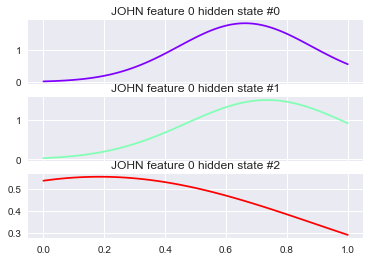

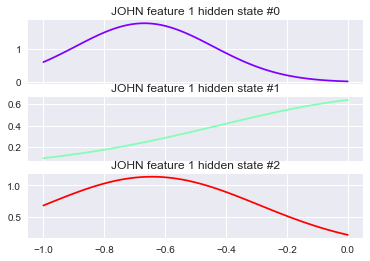

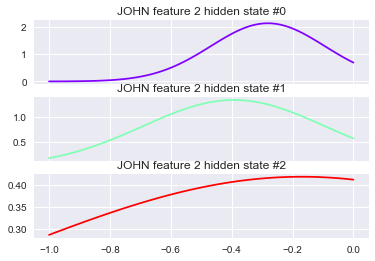

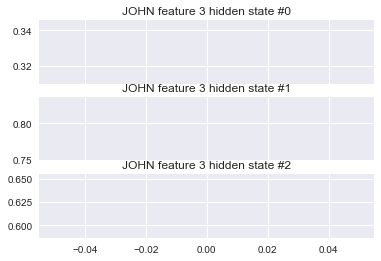

In [55]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        
visualize(my_testword, model)

#####  ModelSelector class
Review the `ModelSelector` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [22]:
from my_model_selectors import SelectorConstant

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
word = 'VEGETABLE' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for VEGETABLE is 3


##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [23]:
#from sklearn.model_selection import KFold

#training = asl.build_training(features_ground) # Experiment here with different feature sets
#word = 'VEGETABLE' # Experiment here with different words
#word_sequences = training.get_word_sequences(word)
#print(word_sequences)
#split_method = KFold()
#for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
#    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [24]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit

In [25]:
# TODO: Implement SelectorCV in my_model_selector.py
%load_ext autoreload
%autoreload 2
from my_model_selectors import SelectorCV

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {:.2f} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 3 states with time 0.02 seconds
Training complete for BOOK with 2 states with time 6.90 seconds
Training complete for VEGETABLE with 14 states with time 2.98 seconds
Training complete for FUTURE with 2 states with time 7.24 seconds
Training complete for JOHN with 12 states with time 79.42 seconds


In [26]:
# TODO: Implement SelectorBIC in module my_model_selectors.py
from my_model_selectors import SelectorBIC

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {:.2f} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 2 states with time 0.47 seconds
Training complete for BOOK with 15 states with time 2.81 seconds
Training complete for VEGETABLE with 15 states with time 1.03 seconds
Training complete for FUTURE with 15 states with time 2.91 seconds
Training complete for JOHN with 15 states with time 28.05 seconds


In [27]:
if True:
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14)
    model.X.shape

In [28]:
# TODO: Implement SelectorDIC in module my_model_selectors.py
from my_model_selectors import SelectorDIC

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 5 states with time 1.5638762949965894 seconds
Training complete for BOOK with 15 states with time 5.33464433500194 seconds
Training complete for VEGETABLE with 15 states with time 4.084202873025788 seconds
Training complete for FUTURE with 15 states with time 5.334783984988462 seconds
Training complete for JOHN with 5 states with time 27.468096202996094 seconds


**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:**
Expecting different results from __cross validation__ would assume to have heterogenuos test data. Given the sparsity of the test data we have for some words this is the case for us and may even be critical for us, to the point that we don't have enough samples for even creating three folds.

As a general rule more parameters will allow for the same or better training accuracy, but may generalize worse than a simpler model. The __Bayesian IC__ will balance gains in accuracy with a penality for more parameters. 
It is important to understand that this already makes it possible to reduce overfitting during the training without the need to look at the test/validation data.
In comparison to the other two it only evaluates each LogL once, so when trying out combinations of features below I resorted to BIC as I expect it to be less computionatial expensive and therefore it allows for more combinations to be tested during the same time span.

The __Discriminative Information Criterion__ focuses not so much on the accuracy of the word it is currently trained on, but on the ability to discriminate. It does so, by letting the training accuracy for a word compete with the average training accuracy of all other words.

<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [29]:
from asl_test_model_selectors import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 81.297s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [30]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

from my_model_selectors import SelectorConstant

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features_ground, SelectorConstant)
print("Number of word models returned = {}".format(len(models)))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [31]:
test_set = asl.build_test(features_ground)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [39]:
# TODO implement the recognize method in my_recognizer
from my_recognizer import recognize
from asl_utils import show_errors

In [48]:
import seaborn as sns

all_features = [features_delta, 
                features_ground, 
                features_norm, 
                features_polar, 
                features_custom2,
                features_custom, 
                features_raw_scaled, 
                features_ground_scaled,
                features_custom2 + features_ground_scaled]
#all_features = [features_custom]

all_selectors = [SelectorDIC, SelectorBIC, SelectorCV]

def run_validation(feature_sets, selectors, run_name, verbose=True):
    
    results = [] # (features, selector, error_rate)
    total_runs = len(feature_sets) * len(selectors)
    run_count = 0
   
    if verbose:
        print("**************************************************************")
        print("*** Look at the bottom of the console output for a summary ***")
        print("**************************************************************")
    else:
        print(str(total_runs)+" model(s) to be trained: ", end='')
    
    for features in feature_sets:
        for selector in selectors:

            run_count += 1
            if verbose:
                print("\n=================(", run_count, "/", total_runs, ")")
                print(selector, features)
                print("=================")
            else:
                if run_count % 10 == 0:
                    print(' ', end='')
                print('.', end='')
                
            models = train_all_words(features, selector)
            test_set = asl.build_test(features)
            probabilities, guesses = recognize(models, test_set)
            error_rate = show_errors(guesses, test_set, verbose)
            results.append((str(features).strip('[]').replace('\'', ''), selector.__name__, error_rate))

    # Create Excel sheet
    resultsDf = pd.DataFrame(results, columns=['Features', 'Selector', 'Error Rate'])
    writer = pd.ExcelWriter(run_name+".xlsx")
    resultsDf.to_excel(writer, "Results")
    writer.save()
    
    # Create diagram (appears at the *end* of the console output)
    cm = sns.light_palette("red", as_cmap=True)
    return resultsDf.style.background_gradient(cmap=cm).set_precision(2)

In [41]:
results_all = run_validation(all_features, all_selectors, "all")
results_all

**************************************************************
*** Look at the bottom of the console output for a summary ***
**************************************************************

=================( 1 / 27 )
<class 'my_model_selectors.SelectorDIC'> ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']
WER 0.6460674157303371
Total correct: 63 out of 178
Video  Recognized                                                    Correct
    2: JOHN *CAR *ARRIVE                                             JOHN WRITE HOMEWORK
    7: JOHN *BOX *GIVE1 *ARRIVE                                      JOHN CAN GO CAN
   12: JOHN *BOX *LOVE CAN                                           JOHN CAN GO CAN
   21: JOHN *MARY *LOVE *MARY *CAR *ARRIVE *FUTURE *MARY             JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *IX *JOHN IX IX                                          JOHN LIKE IX IX IX
   28: JOHN *MARY *JOHN IX *SHOULD                                   JOHN LIKE IX IX IX
   30: JOHN *IX *SHO

In [43]:
results_all

**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:**
Scanning over the n-grams presentation from Part 4 it seems that applying a technique from NLP to use the word(s)/sign(s) before the words/sign to recognize as prior would make the predictions much more accurate. But I didn't implement that.

I enumerate my observations below:

## Observation: Accuracy of Selectors
The different selectors seem to be working on the same level of accuracy. 
Edge cases may be different. One case would be were we have very few training samples or a very large number of parameters.

Another case when we train using a larger number of features. Then DIC seems to have a leg up. This makes intuitively sense to me as a larger number of features could more easily lead to overfitting, 
but DIC already takes this into account when running the current word's accuracy against all other words' accuracies.

The examples belows show in rows 0-2 a model with few features, where all selectors work roughly on the same level.

Rows 3-5 and 6-8 show examples with more features, where DIC performs consistently better than the other two.

In [50]:
features = [features_ground_scaled,
            features_custom2 + features_ground_scaled, 
            ['delta-lx', 'delta-ly', 'delta-rx', 'delta-ry', 
             'left-x-norm', 'left-y-norm', 'polar-lr', 'polar-ltheta', 
             'polar-rr', 'polar-rtheta', 'right-x-norm', 'right-y-norm']]
run_validation(features, all_selectors, "selectors", False)

9 model(s) to be trained: .........

## Observation: Normalisation on Angles
As anticipated in part 1, indeed, adding normalization to an angle, 
does not yield a better accuracy as compared to the raw angle. It does however for the magnitude.

Row 0 shows the polar features without normalisation. Row 1 shows normalisation applied to the magnitudes (lr, rr), which yields the best result. Row 2 shows normalisation applied to all polar features, resulting in the worst error rate.

In [49]:
run_validation([features_polar, features_custom2, features_custom], [SelectorBIC], "normalisation", False)

3 model(s) to be trained: ...

## Observation: Combining Features

Using a combination of more features sometimes does cause better results. A large factor here is to avoid overfitting and DIC seems to be helpful in this regard when selecting models.

I didn't find a model with three feature sets combined that would be the best model with two features sets combined.

_The actual selection of these features was done on another notebook and took a long time, so the details are not included here. However one, maybe obvious thing, to point out is that a larger number of features did not improve the results, but adding distinct, non-overlapping, features did. Also features that were standalone meaningless were then contributing as well, e.g. the delta based features._

In [56]:
best_2 = features_raw_scaled + features_custom2
best_3 = features_ground_scaled + features_raw_scaled + features_custom2
run_validation([best_2, best_3], [SelectorDIC], "best_combined_features", False)

2 model(s) to be trained: ..

In [57]:
## 
## I ran there in a different notebook to utilize the addiitonal cores 
## of my machine that a single notebook with this approach wouldn't
## and used the results from there here to pick features in this notebook
##
features_subset = [features_delta, 
                   features_ground, 
                   features_norm, 
                   features_polar, 
                   features_custom2,
                   features_raw_scaled, 
                   features_ground_scaled]

def combinations3(features):
    result = []
    for a in features:
        for b in features:
            if a == b: 
                continue
            for c in features:
                if b == c or a == c:
                    continue
                value = sorted(a + b + c)
                if value not in result:
                    result.append(value)
    return result


def combinations2(features):
    result = []
    for a in features:
        for b in features:
            if a == b: 
                continue
            value = sorted(a + b)
            if value not in result:
                result.append(value)
    return result

if False:
    two_combined_features   = combinations2(features_subset)
    three_combined_features = combinations3(features_subset)

    print("2", two_combined_features)
    print("2", len(two_combined_features))
    print("3", three_combined_features)
    print("3", len(three_combined_features))

<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [58]:
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 42.118s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

<a id='part4_info'></a>
## PART 4: (OPTIONAL)  Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!